In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from fedland.utils import load_all_training_results, get_experiment_description, plot_results_overview

## Experiments 5 Clients, Cifar-10, Resnet

In [2]:
df = load_all_training_results(results_path="../results")
experiment_ids = [
    "9070ebff-43ab-4eeb-9a8a-d64024ee8e04",
    "b458a5f7-193a-46f4-97d5-aac510bb5952",
    "64b57f5d-dbaf-4ffb-b9db-396ca6f73edc",
    "4b3a8ef9-c2ee-4a01-9260-6e4af635dc03",
    "410ad360-b445-4ae8-b224-6f997845a9b1",
    "3f6c270c-ff3d-4c1d-a01c-3359312cd3c4",
    "5f5b1857-84e7-4620-aa9c-77f9ea5e12da",
    "9d0054da-149f-4a8b-aa2c-6583ba8f7484",
]
df = df[df["experiment_id"].isin(experiment_ids)]
df = df.sort_values(by=["experiment_id", "client_index", "timestamp"])
df['iteration'] = df.groupby(['experiment_id', 'client_index']).cumcount() + 1
df = df.reset_index()
# for _, row in df.loc[0:100].iterrows():
#     print(f"ci:{row['client_index']}, i:{row['iteration']}")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3495 entries, 0 to 3494
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              3495 non-null   int64         
 1   epoch              3495 non-null   int64         
 2   learning_rate      3495 non-null   float64       
 3   batch_size         3495 non-null   int64         
 4   len_train_indices  3495 non-null   int64         
 5   len_test_indices   3495 non-null   int64         
 6   momentum           3495 non-null   float64       
 7   train_loss         3495 non-null   float64       
 8   train_accuracy     3495 non-null   float64       
 9   test_loss          3495 non-null   float64       
 10  test_accuracy      3495 non-null   float64       
 11  path_norm          3495 non-null   float64       
 12  global_path_norm   3495 non-null   float64       
 13  timestamp          3495 non-null   datetime64[ns]
 14  client_i

['Resnet CIFAR-10, 5 clients, non-IID, balanced, fedopt', 'Resnet CIFAR-10, 5 clients, non-IID, balanced, fedavg', 'Resnet CIFAR-10, 5 clients, IID, imbalanced, fedopt', 'Resnet CIFAR-10, 5 clients, non-IID, imbalanced, fedavg', 'Resnet CIFAR-10, 5 clients, IID, imbalanced, fedavg', 'Resnet CIFAR-10, 5 clients, IID, balanced, fedavg', 'Resnet CIFAR-10, 5 clients, non-IID, imbalanced, fedopt', 'Resnet CIFAR-10, 5 clients, IID, balanced, fedopt']


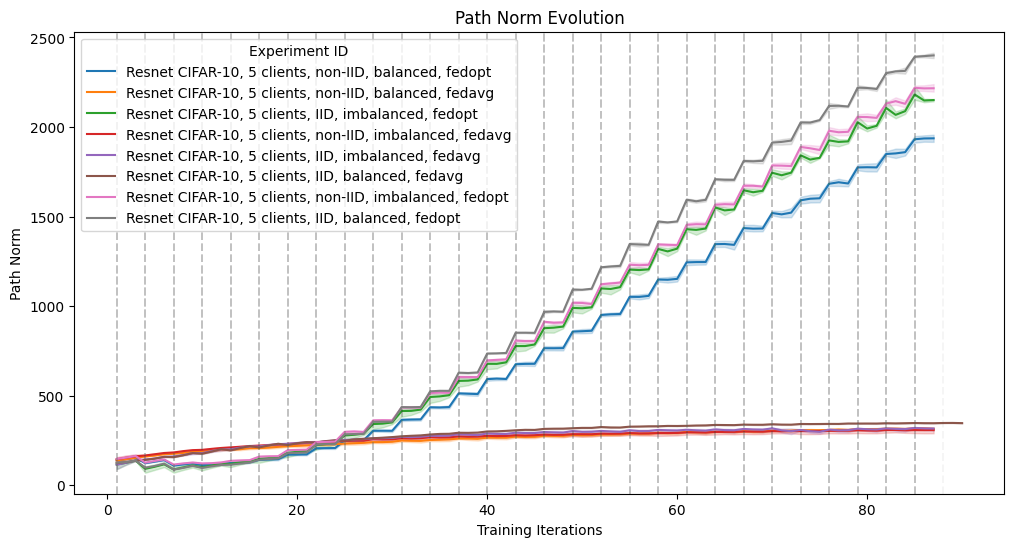

In [3]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="iteration", y="path_norm", hue="experiment_id")
# sns.lineplot(data=df, x="iteration", y="global_path_norm", hue="experiment_id")
for epoch_val in df[df['epoch'] == 0]['iteration']:
    plt.axvline(x=epoch_val, color='gray', linestyle='--', alpha=0.01)
plt.title("Path Norm Evolution")
plt.xlabel("Training Iterations")
plt.ylabel("Path Norm")
handles, labels = plt.gca().get_legend_handles_labels()
aliased_labels = [get_experiment_description(label, "../results") for label in labels]
print(aliased_labels)
plt.legend(handles=handles, labels=aliased_labels, title="Experiment ID")
plt.show()

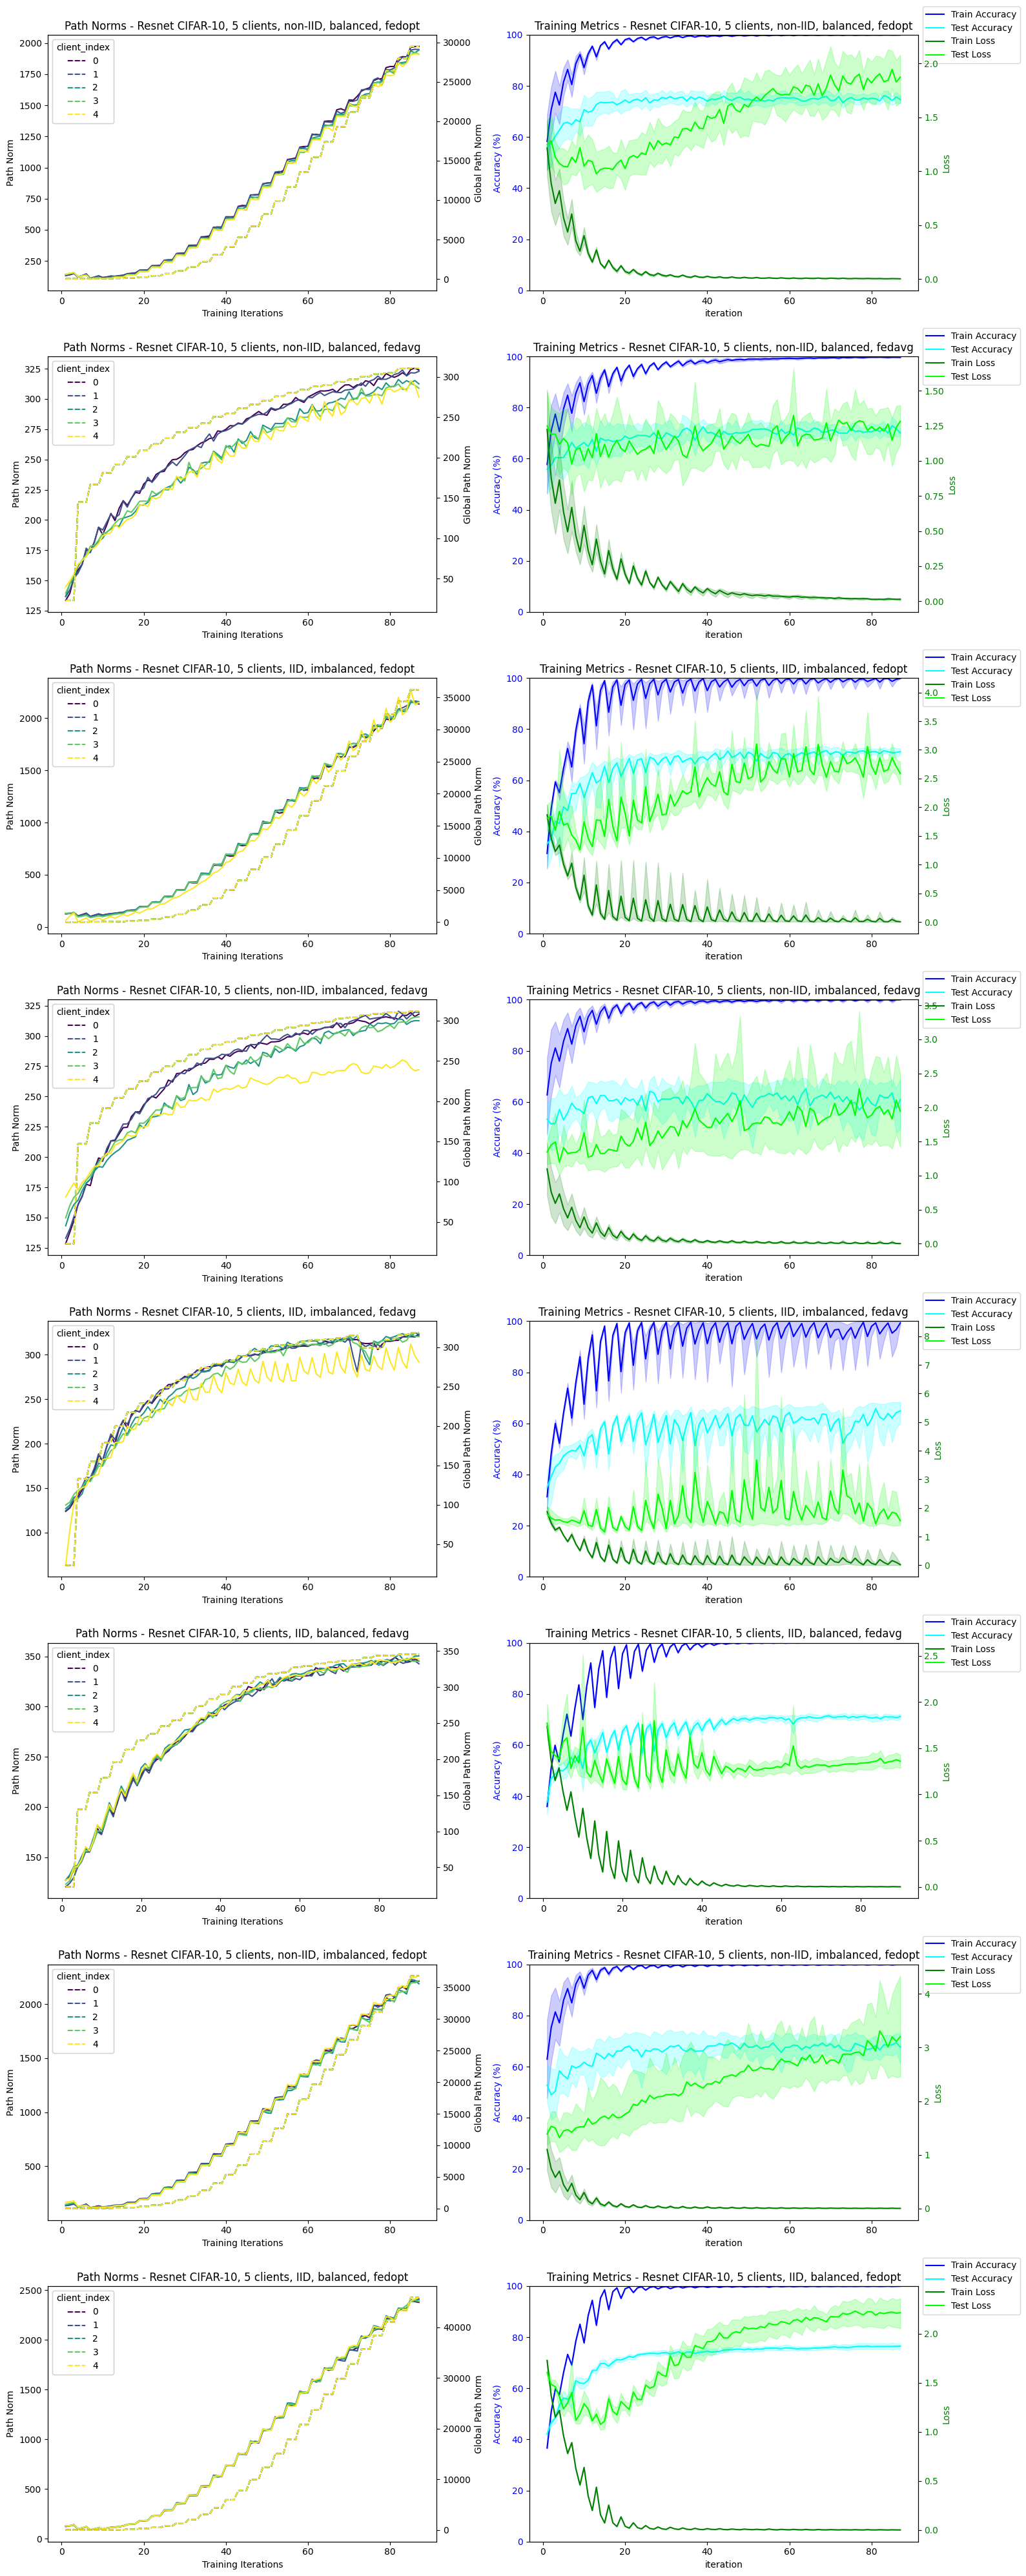

In [4]:
plot_results_overview(df, "../results")